In [1]:
from acquire import *
from prepare import *

import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import Holt
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv("GlobalLandTemperaturesByCountry.csv",parse_dates=['dt'])
df = df.rename(columns = {"dt" : "date"})
pd.to_datetime(df.date)
df = df.set_index('date')
df.head(3)

,AverageTemperature,AverageTemperatureUncertainty,Country
date,,,
1743-11-01,4.384,2.294,Åland
1743-12-01,NaN,NaN,Åland
1744-01-01,NaN,NaN,Åland


It is mentioned in the published paper that data after 1960 is more reliable and robust. I will be using only dates after that data for exploration and modeling.

In [3]:
df = df.loc[df['Country'].isin(["Africa", "Antarctica", "Asia", "Australia", "Europe", "North America", "South America"])]
df = df.loc[df.index > "1959-12-31"]
df = df.dropna()
display(df.head(3))
display(df.tail(3))

,AverageTemperature,AverageTemperatureUncertainty,Country
date,,,
1960-01-01,21.010,0.169,Africa
1960-02-01,22.817,0.258,Africa
1960-03-01,23.841,0.194,Africa


,AverageTemperature,AverageTemperatureUncertainty,Country
date,,,
2013-06-01,20.734,0.225,South America
2013-07-01,20.076,0.167,South America
2013-08-01,20.541,0.248,South America


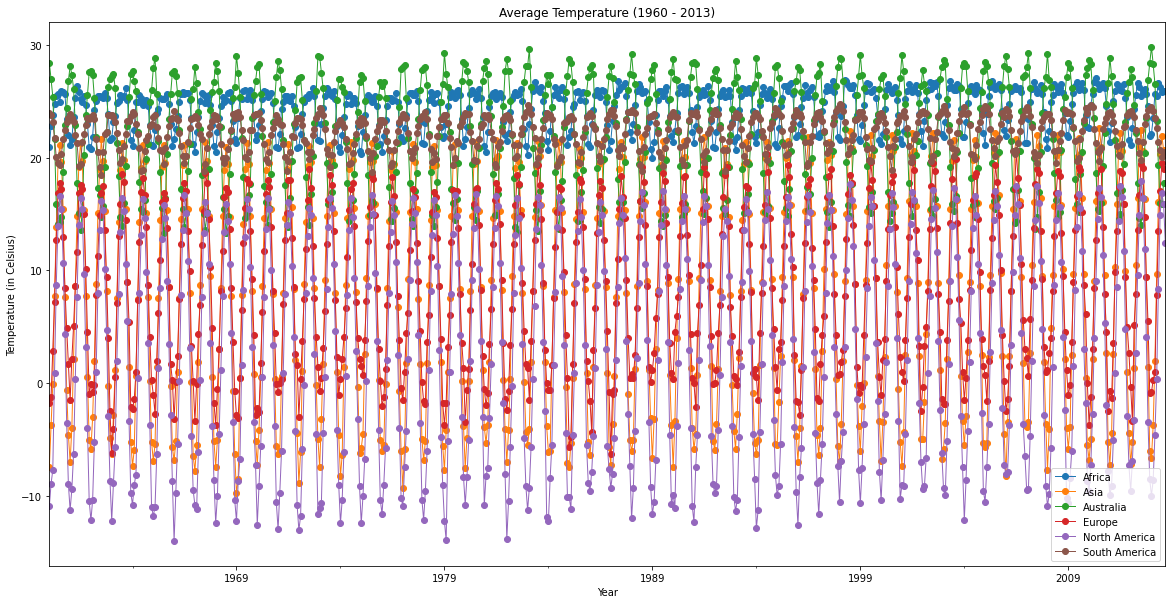

In [4]:
fig, ax = plt.subplots(figsize = (20, 10))
continents = df.groupby(df.Country)
continents.AverageTemperature.plot(linewidth = 1, marker="o")
plt.title('Average Temperature (1960 - 2013)')
plt.xlabel('Year')
plt.ylabel('Temperature (in Celsius)')
plt.legend()
plt.show()

            AverageTemperature  AverageTemperatureUncertainty
date                                                         
1960-12-31           14.274306                       0.219931
1961-12-31           14.488764                       0.199778
1962-12-31           14.340514                       0.245750
1963-12-31           14.352875                       0.199597
1964-12-31           14.103458                       0.201542
1965-12-31           14.171653                       0.236431
1966-12-31           14.219486                       0.192708
1967-12-31           14.310611                       0.195944
1968-12-31           14.147194                       0.180583
1969-12-31           14.265583                       0.184403
1970-12-31           14.294944                       0.185931
1971-12-31           14.168903                       0.172389
1972-12-31           14.196028                       0.190069
1973-12-31           14.569528                       0.196750
1974-12-

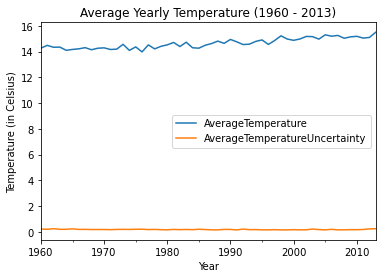

In [5]:
print(df.resample('Y').mean())

df.resample('Y').mean().plot()
plt.title('Average Yearly Temperature (1960 - 2013)')
plt.xlabel('Year')
plt.ylabel('Temperature (in Celsius)')
plt.legend()
plt.show()

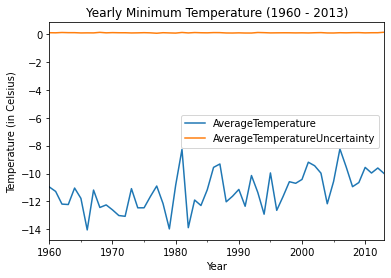

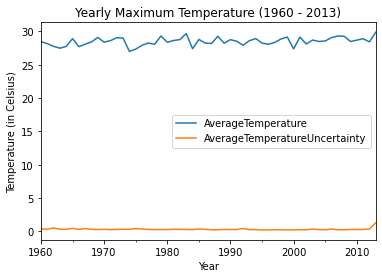

In [6]:
df.resample('Y').min().plot()
plt.title('Yearly Minimum Temperature (1960 - 2013)')
plt.xlabel('Year')
plt.ylabel('Temperature (in Celsius)')
plt.legend()
plt.show()

df.resample('Y').max().plot()
plt.title('Yearly Maximum Temperature (1960 - 2013)')
plt.xlabel('Year')
plt.ylabel('Temperature (in Celsius)')
plt.legend()
plt.show()

In [7]:
def time_split(df):
    train_size = int(len(df) * 0.5)
    val_size = int(len(df) * 0.3)
    test_size = int(len(df) - train_size - val_size)
    val_end_index = train_size + val_size
    train = df[ : train_size]
    validate = df[train_size : val_end_index]
    test = df[val_end_index : ]
    return train, validate, test

In [8]:
pd.to_numeric(df.index, errors = 'coerce',downcast='integer')
train, validate, test = time_split(df)

In [9]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    pd.plotting.register_matplotlib_converters()
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    plt.xticks(range(0,len(train.index)), train.index)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.legend()
    plt.show()

In [10]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [11]:
last_temp = train['AverageTemperature'][-1:][0]
last_temp

yhat_df = pd.DataFrame(
    {'AverageTemperature': [last_temp]},
    index=validate.index)

yhat_df.head(3)

,AverageTemperature
date,
1960-01-01,17.748
1960-02-01,17.748
1960-03-01,17.748


AverageTemperature -- RMSE: 15


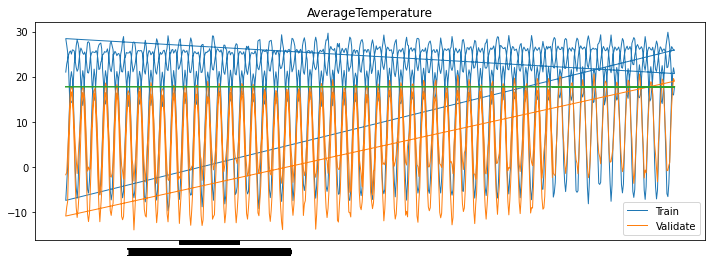

In [12]:
plot_and_eval("AverageTemperature")

In [13]:
print(round(train['AverageTemperature'].rolling(3).mean()[-1], 2))


16.57


In [33]:
train = df.loc[:'2010']
validate = df.loc['2011']
test = df.loc['2012']

display(train.tail(3))

yhat_df = train.AverageTemperature.loc["2010"] + train.AverageTemperature.diff(12)
display(yhat_df)

,AverageTemperature,AverageTemperatureUncertainty,Country
date,,,
2010-10-01,23.111,0.108,South America
2010-11-01,23.550,0.103,South America
2010-12-01,23.993,0.254,South America


date
1960-01-01       NaN
1960-01-01       NaN
1960-01-01       NaN
1960-01-01       NaN
1960-01-01       NaN
               ...  
2010-12-01    24.289
2010-12-01    22.609
2010-12-01    21.520
2010-12-01    24.854
2010-12-01    23.990
Name: AverageTemperature, Length: 4032, dtype: float64

KeyError: 'AverageTemperature'

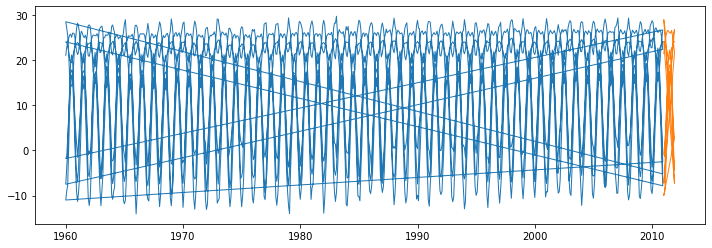

In [35]:
plot_and_eval("AverageTemperature")